In [1]:
import torch
from model import TCPredict

MODEL_TO_LOAD="models/50_epochs_500_8points.model"

model = TCPredict(initial_timesteps=8,fc_width=200)
model = model.double()
model.load_state_dict(torch.load(MODEL_TO_LOAD,map_location=torch.device('cpu')))
model.eval()

TCPredict(
  (conv1): Conv1d(8, 20, kernel_size=(3,), stride=(1,))
  (conv2): Conv1d(20, 20, kernel_size=(3,), stride=(1,))
  (fc_1): Linear(in_features=80, out_features=200, bias=True)
  (output): Linear(in_features=200, out_features=4, bias=True)
)

In [2]:
import util
ibtracs_ds = util.get_dataset()
sst_ds = util.get_sst_ds()
_,_,test_storms = util.train_validation_test(ibtracs_ds,seed=42)

test_storm_seed,test_tracks,test_start_times = util.get_storm_seeds(ibtracs_ds,sst_ds,test_storms,timestep=8)

In [3]:
X_test,y_test,group_test = util.make_X_y(ibtracs_ds,sst_ds,test_storms,timesteps=8)

In [4]:
import numpy as np
X_test = np.transpose(X_test,axes=(0,2,1))

In [5]:
from torch.utils.data import DataLoader
X_test_tensor = torch.from_numpy(X_test)
loader = DataLoader(X_test_tensor)

In [17]:
y_pred = torch.zeros((X_test.shape[0],4))
for i,X in enumerate(loader):

    y_pred[i]=model(X)


: 

: 

TCPredict(
  (conv1): Conv1d(8, 20, kernel_size=(3,), stride=(1,))
  (conv2): Conv1d(20, 20, kernel_size=(3,), stride=(1,))
  (fc_1): Linear(in_features=80, out_features=200, bias=True)
  (output): Linear(in_features=200, out_features=4, bias=True)
)

In [7]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y_test,y_pred.detach().numpy(),multioutput='raw_values',squared=False)


array([4.87236387, 9.76017542, 2.76893395, 2.9635098 ])

In [12]:
from geopy.distance import distance
from geopy.point import Point
from datetime import timedelta
def get_predicted_latlon_from_speed(lat,lon,u,v):
    d = np.sqrt(u**2 + v**2)*3*1.852 ## convert to kilometers across 6 hours intervals
    bearing = np.rad2deg(np.arctan2(u,v))
    predicted = distance(kilometers=d).destination(Point(latitude=lat,longitude=lon),bearing)
    return predicted.latitude,predicted.longitude

def coriolis_parameter(lat):
    return 2*np.sin(np.deg2rad(lat))


def recursive_prediction(initial_x,model,length,start_time):
    y = np.zeros((length,6))

    timestep = initial_x.shape[0]
    y[:timestep] = initial_x[:,[0,1,2,3,6,7]]
    x = torch.transpose(torch.from_numpy(initial_x),0,1)
    for step in range(length - timestep):
        out = model(x[None,:,:])
        uMax,Pmin,u,v = out.detach().numpy()[0]
        old_lat,old_lon = x[-2,-1],x[-1,-1]
        interp_lat,interp_lon = get_predicted_latlon_from_speed(old_lat,old_lon,u,v)
        cor_param= coriolis_parameter(interp_lat)
        sst = float(sst_ds.sst.interp(time=start_time+np.timedelta64((3)*(step+1),'h'),lat=interp_lat,lon=interp_lon))
        if np.isnan(sst):
            sst = x[5][-1]
        y[step+timestep] = [uMax,Pmin,u,v,interp_lat,interp_lon]
        x = torch.roll(torch.transpose(x,0,1),-1,dims=0)
        x[-1] = torch.tensor([uMax,Pmin,u,v,cor_param,sst,interp_lat,interp_lon])
        x = torch.transpose(x,0,1)
    return y 

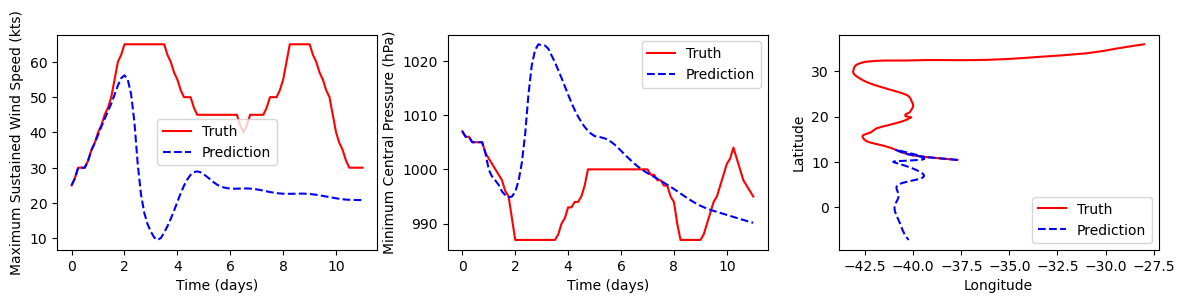

In [22]:
import matplotlib.pyplot as plt
import numpy as np
STORM = 50
prediction_length = len(test_tracks[STORM]) 
storm_prediction = recursive_prediction(test_storm_seed[STORM],model,prediction_length,test_start_times[STORM])
t=np.arange(0,prediction_length/8,0.125)
fig,ax = plt.subplots(ncols=3,nrows=1,figsize=(12,3))
fig.tight_layout(pad=2)
ax[0].plot(t[:len(test_tracks[STORM])],test_tracks[STORM][:,0],'r-',label='Truth')
ax[0].plot(t,storm_prediction[:,0],'b--',label='Prediction')
ax[0].set_xlabel("Time (days)")
ax[0].set_ylabel("Maximum Sustained Wind Speed (kts)")
ax[0].legend()
ax[1].plot(t[:len(test_tracks[STORM])],test_tracks[STORM][:,1],'r-',label='Truth')
ax[1].plot(t,storm_prediction[:,1],'b--',label='Prediction')
ax[1].set_xlabel("Time (days)")
ax[1].set_ylabel("Minimum Central Pressure (hPa)")
ax[1].legend()

ax[2].plot(test_tracks[STORM][:,-1],test_tracks[STORM][:,-2],'r-',label='Truth')
ax[2].plot(storm_prediction[:,-1],storm_prediction[:,-2],'b--',label='Prediction')
ax[2].set_xlabel("Longitude")
ax[2].set_ylabel("Latitude")
ax[2].legend()
fig.savefig(f"plots/model_test_{STORM}.png")